In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import ncempy.io as nio
from utils import FilePath
from psm.image import preprocess
from bm3d import bm3d
from skimage.restoration import rolling_ball
from scipy.spatial import Voronoi
from voronoi import*

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

In [2]:
path = FilePath()
data = nio.read(path[0])
img = data['data']
pixsize = data['pixelSize']

Now,b get 1 files
('C:/Users/zhuch/Messy Tasks/NAM/CrxW1-xS2_Gradient/Selected/20200723 1404 STEM Diffraction HAADF 5.5 Mx_HAADF.dm3',)


In [3]:
image = np.array(img).astype(float)
image = preprocess.normalize_range(img)
image = preprocess.remove_hot_pixels(img)
filtered = bm3d(image, 40)
bkg = rolling_ball(filtered, radius=15)
img_sbkg = filtered - bkg
img_sbkg = preprocess.normalize_range(img_sbkg)
img_sbkg = preprocess.remove_hot_pixels(img_sbkg)
#from skimage.filters import gaussian
#filtered2 = gaussian(img_sbkg, sigma=.9)
from psm.image.peaks import find_local_peaks

unrefined_peaks = find_local_peaks(img_sbkg, min_distance=10, local_threshold=.5, exclude_border=5, exclude_adjacent=True)

from psm.image import refine_peaks, Polynomial2D

model = Polynomial2D()
peaks = refine_peaks(img_sbkg, unrefined_peaks, model=model, extent=3, progress_bar=True)

 [||||||||||||||||||||] 3529/3529 fits


In [4]:
from RDF import RDF_calculator
rdf = RDF_calculator(peaks, [1024,1024], pixsize[1:], 2048)
rdf.cal_rdf()
g = rdf.g

C:\Users\zhuch\AppData\Local\Temp\ipykernel_48040\4238200229.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(g[:, 0], g[:, 1], 'k', lw=1, c='#34495E')  # 01719B


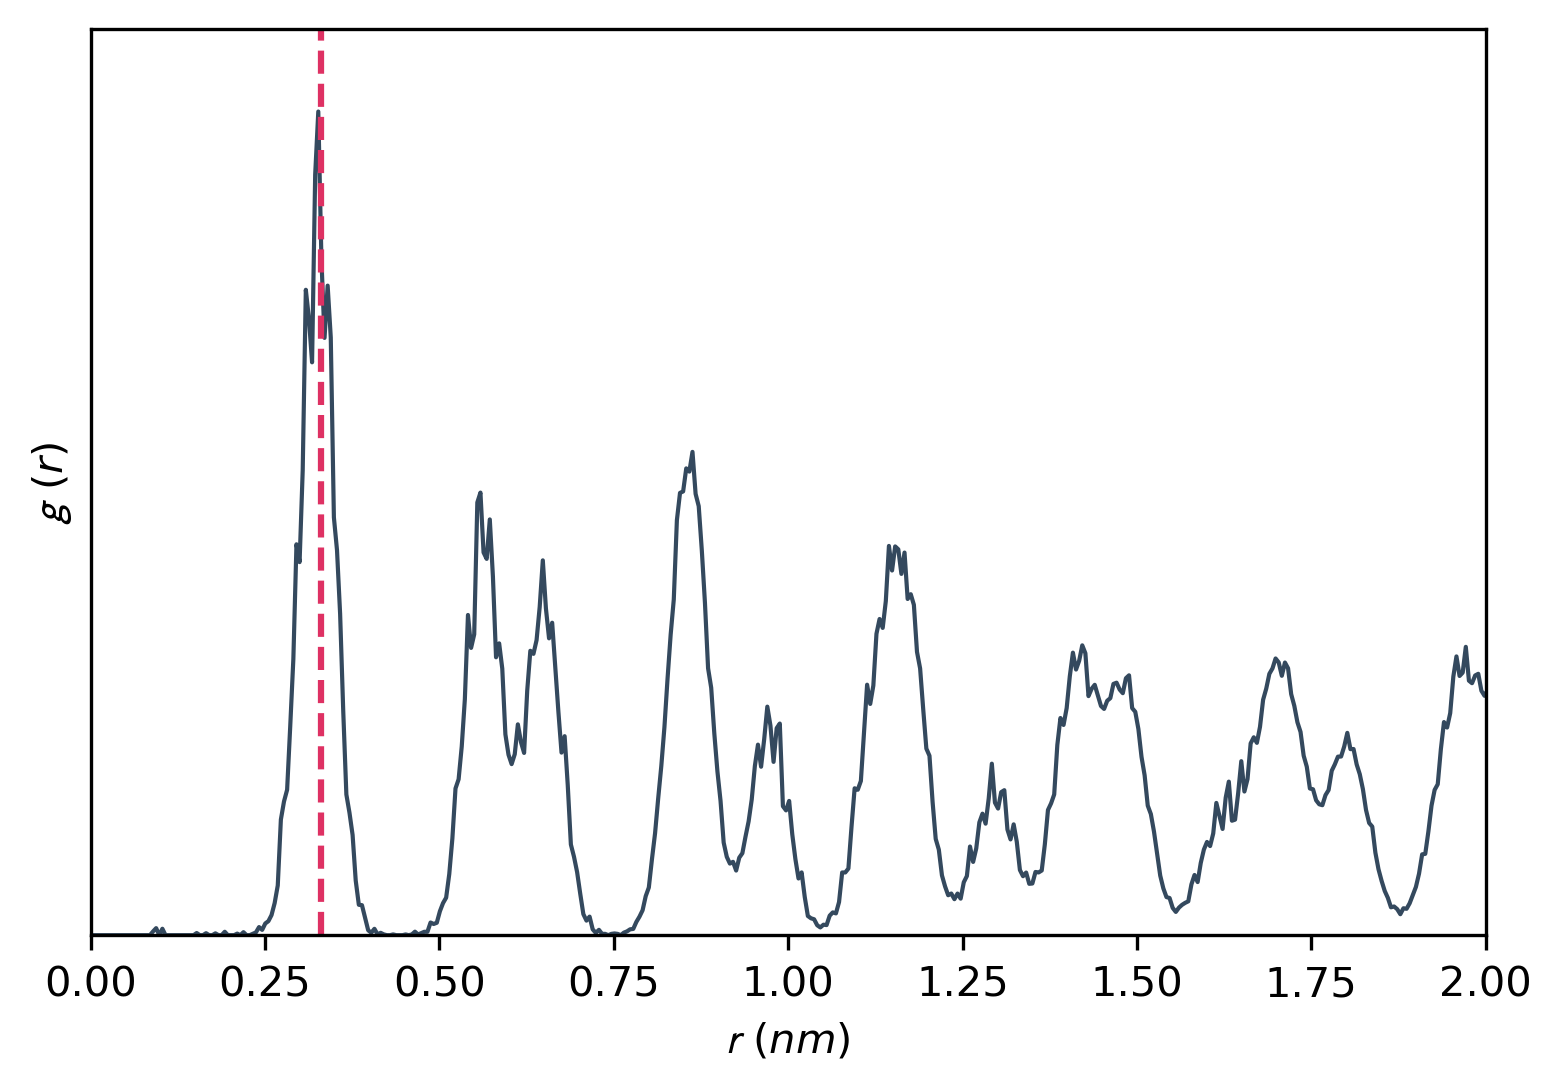

In [5]:
fig, ax = plt.subplots()
ax.plot(g[:, 0], g[:, 1], 'k', lw=1, c='#34495E')  # 01719B
ax.set_xlim([0,2])
ax.set_ylim([0,g[:,1].max()*1.1])
ax.set_yticks([])
ax.set_xlabel(r'$\mathcal{r}\ (nm)$')   
ax.set_ylabel(r'$\mathcal{g}\ (r)$')
ax.vlines(.33, 0, g[:,1].max()*1.1, lw=1.5, color='#DE3163', ls='--')

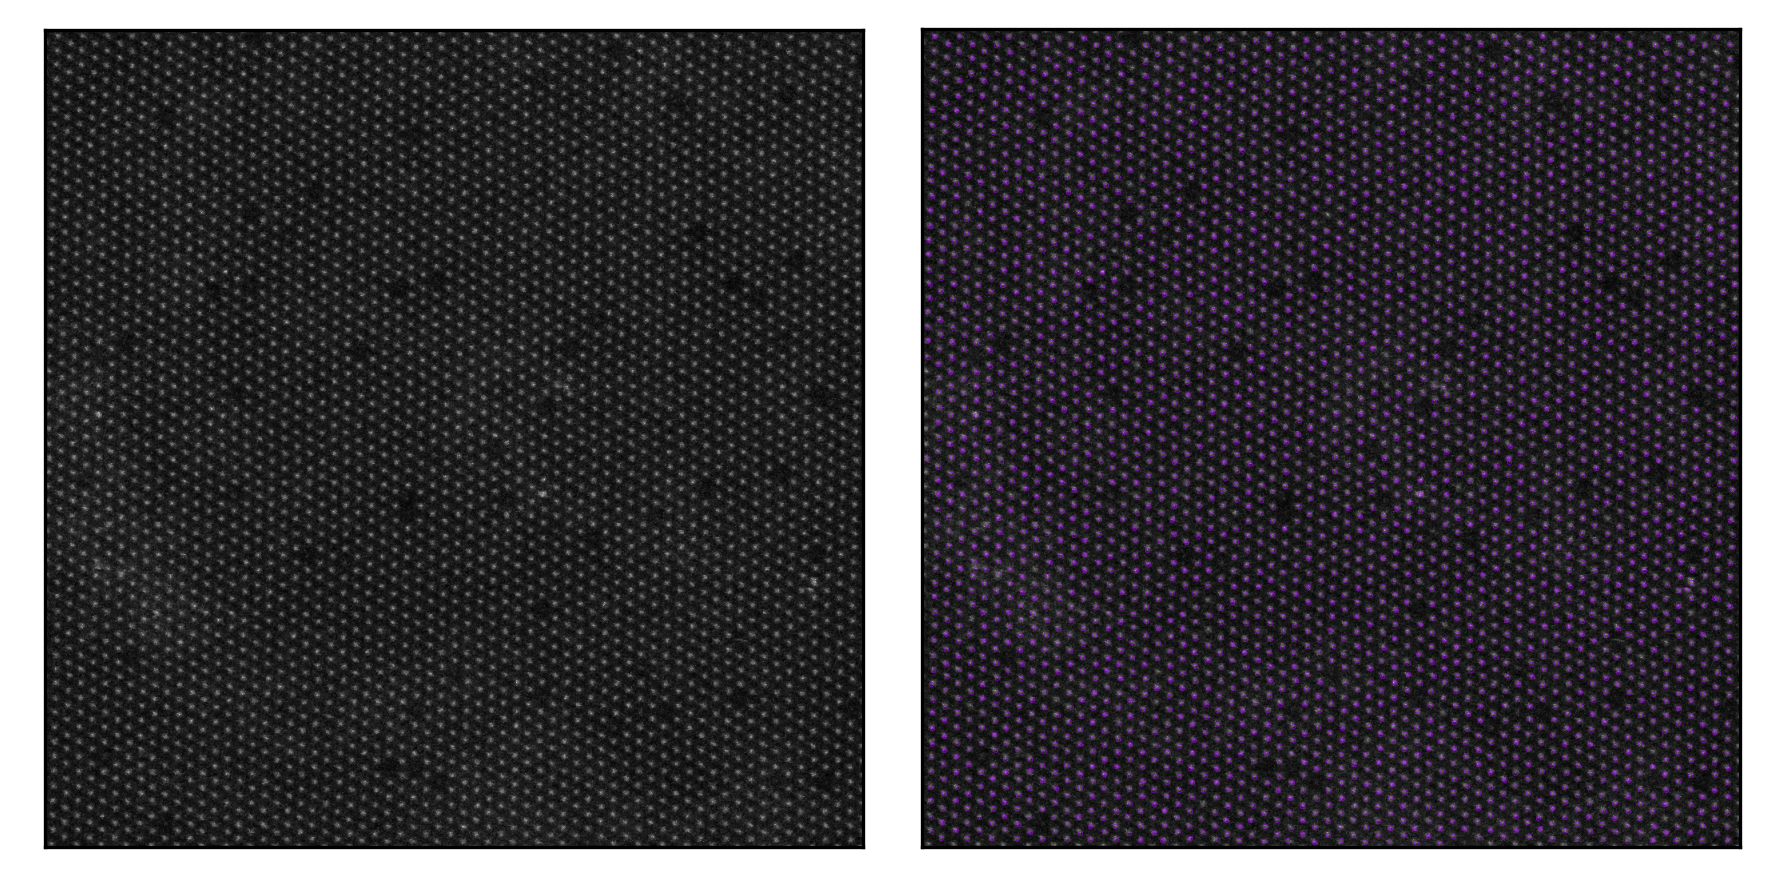

In [6]:
from atoms import*
atom_collection = Atoms(peaks) #turn coordinates and labels into Atoms
clusters = clustering(atom_collection) # making Atoms into clusters mode
clusters.partition(20) # define every single clusters
centroids = clusters.centroids
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].imshow(filtered, cmap='gray')
ax[1].imshow(filtered, cmap='gray')
ax[1].scatter(peaks[:,1], peaks[:,0], s=.3, c='#A300F5', alpha=.5, marker='.')
#ax[2].imshow(filtered, cmap='gray')
#ax[2].scatter(centroids[:,0], centroids[:,1], s=.1, c='#00F5EA', alpha=.8, marker='8')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlim(0, 1024)
ax[0].set_ylim(0, 1024)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlim(0, 1024)
ax[1].set_ylim(0, 1024)
#ax[2].set_xticks([])
#ax[2].set_yticks([])
#ax[2].set_xlim(0, 1024)
#ax[2].set_ylim(0, 1024)
#ax[0].set_axis_off
#ax[1].set_axis_off
fig.tight_layout()

In [7]:
clusters.slenderness_calc()
vor = Voronoi(centroids)
regions, vertices = voronoi_finite_polygons_2d(vor)


UFuncTypeError: Cannot cast ufunc 'inv' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

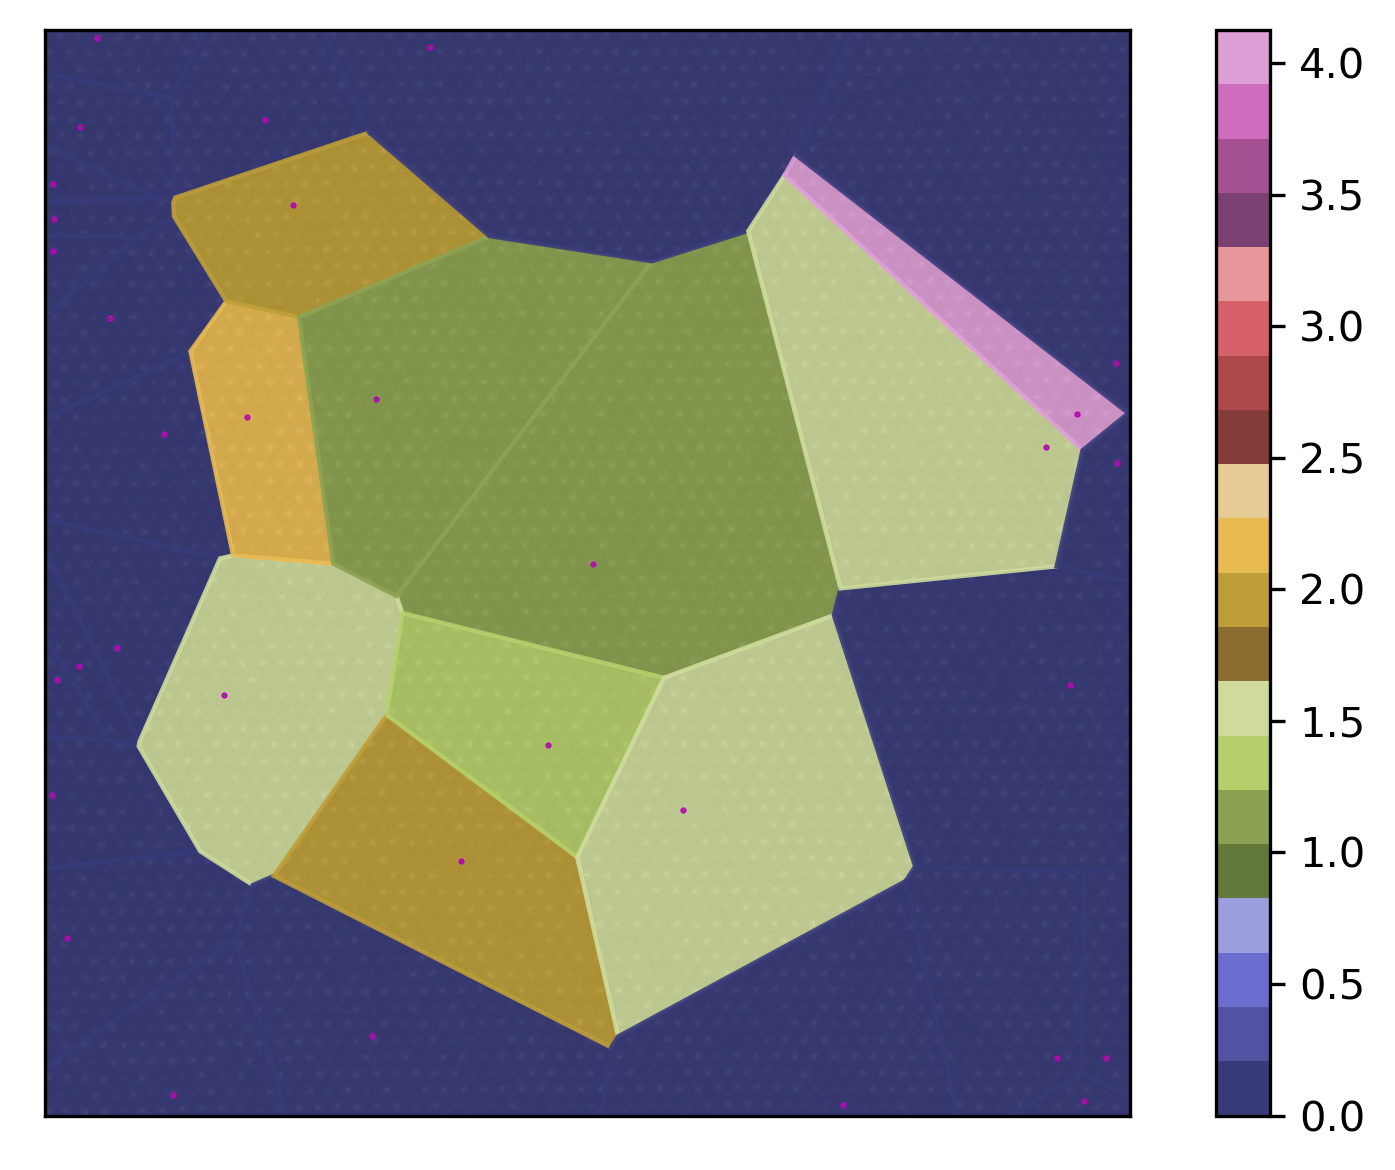

In [ ]:
import matplotlib
import matplotlib.cm as cm
from skimage.measure import EllipseModel

points_augment = clusters.slenderness_points
slenderness = []
effectivenum = 0
for region in regions:
    ellipse = EllipseModel()
    polygon = vertices[region]
    center_v = np.mean(polygon, axis=0).reshape((1, 2))
    keys = np.array([i for i in points_augment.keys()])
    center = np.tile(center_v, (len(keys), 1))
    pos = np.argmin(np.sum((keys-center)**2, axis=1))
    key = tuple(np.round(keys[pos], decimals=3))
    t1 = points_augment[key]
    poly_augmented = np.concatenate((polygon, points_augment[key]), axis=0)
    xx = [x for x in poly_augmented.ravel()]
    if np.all(np.array(xx) > 0) and np.all(np.array(xx) < 1024):
        success = ellipse.estimate(poly_augmented)
        coeffs = ellipse.params
        a = coeffs[2] / coeffs[3]
        b = coeffs[3] / coeffs[2]
        if np.all(coeffs):
            if a > b:
                slender = a
                effectivenum += 1
            else:
                slender = b
                effectivenum += 1
        else:
            slender = 0
    else:
        slender = 0
    slenderness.append(slender)
    
norm = matplotlib.colors.Normalize(
    vmin=min(slenderness), vmax=max(slenderness), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.tab20b)

fig, ax = plt.subplots()
for region, color in zip(regions, slenderness):
    polygon = vertices[region]
    ax.fill(*zip(*polygon), c=mapper.to_rgba(color),
            alpha=0.9)
ax.plot(centroids[:, 0], centroids[:, 1], 'o', ms=.5, mec='m', mfc='g')
ax.imshow(filtered.T, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)
ax.set_aspect(1)
fig.colorbar(mapper, ax=ax)
fig.tight_layout()


In [8]:
from matplotlib.patches import Ellipse

points_augment = clusters.slenderness_points
slenderness = []
ellipse_params = []
for region in regions:
    ellipse = EllipseModel()
    polygon = vertices[region]
    center_v = np.mean(polygon, axis=0).reshape((1, 2))
    keys = np.array([i for i in points_augment.keys()])
    center = np.tile(center_v, (len(keys), 1))
    pos = np.argmin(np.sum((keys-center)**2, axis=1))
    key = tuple(np.round(keys[pos], decimals=3))
    t1 = points_augment[key]
    poly_augmented = np.concatenate((polygon, points_augment[key]), axis=0)
    xx = [x for x in poly_augmented.ravel()]
    if np.all(np.array(xx) > 0) and np.all(np.array(xx) < 1024):
        success = ellipse.estimate(poly_augmented)
        coeffs = ellipse.params
        a = coeffs[2] / coeffs[3]
        b = coeffs[3] / coeffs[2]
        if np.all(coeffs):
            if a > b:
                slender = a
                effectivenum += 1
            else:
                slender = b
                effectivenum += 1
        else:
            slender = 0
    else:
        slender = 0
    slenderness.append(slender)
    ellipse_params.append(coeffs)

norm = matplotlib.colors.Normalize(
    vmin=min(slenderness), vmax=max(slenderness), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.tab20b)

fig, ax = plt.subplots()
for coes, c in zip(ellipse_params, slenderness):
    ax.add_patch(Ellipse([coes[0], coes[1]], coes[2],
                 coes[3], angle=np.degrees(coes[4]), color=mapper.to_rgba(c), ec='c', alpha=.5))
    #ax.fill(*zip(*polygon), c=mapper.to_rgba(color),alpha=0.2)
ax.plot(centroids[:, 0], centroids[:, 1], 'o', ms=.5, mec='m', mfc='g')
#ax.imshow(filtered.T, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)
ax.set_aspect(1)
fig.colorbar(mapper, ax=ax)
fig.tight_layout()


NameError: name 'regions' is not defined